In [2]:
%load_ext autoreload
%autoreload 2

import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import random
import sys
from tifffile import imread

# Change this folder to where the cloned `alignment` repository is
sys.path.insert(0, '/Users/minelarinel/alignment')

from alignment import minmax_scaler
from registration import sitkalignment

logging.getLogger('matplotlib').setLevel(logging.ERROR)

cv2 not available


#### To align the vagal images, we will use the SUM of the anatomy stack of each recording. So unlike hindbrain, which aligns based on a plane in the functional volume, we will align vagal neurons based on a z-projected anatomy image.

In [17]:
# Folder where the experiment folders are
# CHANGE THIS PATH
data_folder = r'/Volumes/Rapid/Arinel_et_al_2025/Data/Fig3'

# Target data
# CHANGE THIS exp_folder to each individual fish's experiment folder
exp_folder_name = 'elavl3H2BGCaMP8m_8dpf_fed_eggwater_0mM_18_20231206'
exp_folder = Path(data_folder).joinpath(exp_folder_name)

# Reference data for alignment
# This image is masked and adjusted for brightness and contrast to improve alignment
source_img_path = Path(r'./reference_images/vagal/SUM_vagal_anatomystack_cutout_bcadjusted.tif')

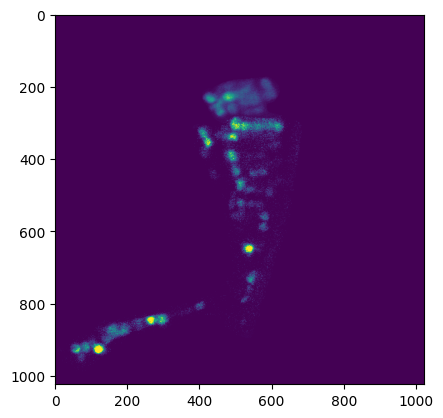

In [18]:
# Load the reference (i.e., source) image
source_img = imread(source_img_path)
source_img = sitkalignment.embed_image(source_img, 1024) # matching image sizes to 1024x1024

source_img = source_img / source_img.max() # rescaling pixel brightness
source_img *= 2**12

plt.imshow(source_img)

In [92]:
# Load the target image
target_img_path = exp_folder.joinpath("anatomy.tif")
target_img = imread(target_img_path)

target_img = np.sum(target_img, axis=0)  # Sum along the z-axis
target_img = sitkalignment.embed_image(target_img, 1024) # matching image sizes to 1024x1024

target_img = target_img / target_img.max() # rescaling pixel brightness
target_img *= 2**12

# Since the reference is a left vagal ganglion, flip the right vagal ganglion recordings
flip_horizontal = False
with os.scandir(exp_folder) as entries:
    for entry in entries:
        if os.path.isdir(entry.path) and entry.name.startswith("vagal_L"):
            break
        elif os.path.isdir(entry.path) and entry.name.startswith("vagal_R"):
            flip_horizontal = True
            target_img = np.fliplr(target_img)
            break

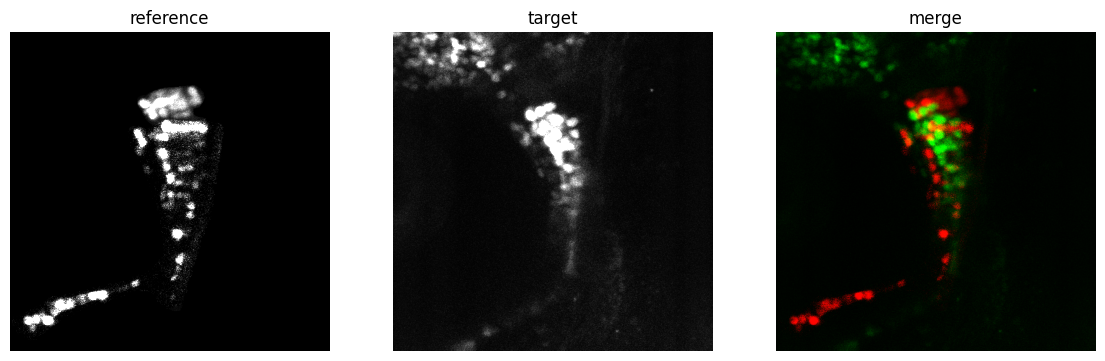

In [93]:
# Visualize unaligned source and target images
# Change the vmin and vmax settings for better visualization and better alignment
# Increasing the contrast of landmarks helps with the alignment
source_vmin = 0
source_vmax = 1000
target_vmin = 0
target_vmax = 1000
plot_img_line_xval = 0  # blocking out top of functional image with 0's
source_img_line_xval = 0  # blocking out top of reference image with 0's

########################################

fig, ax = plt.subplots(1, 3, figsize=(14, 6))

_plot_img = target_img.copy()
_plot_img[0:plot_img_line_xval] = 0

_source_img = source_img.copy()
_source_img[0:source_img_line_xval] = 0

ax[0].imshow(
    _source_img,
    cmap="gray",
    vmin=source_vmin,
    vmax=source_vmax  # max is 4096
)
ax[1].imshow(
    _plot_img, 
    cmap="gray",
    vmin=target_vmin,
    vmax=target_vmax  # max is 4096
)

[a.axis("off") for a in ax]

merge = np.zeros(
    (_source_img.shape[0], _source_img.shape[1], 3)
)  # assumes same size images
merge[:, :, 0] = 2 * _source_img / _source_img.max()
merge[:, :, 1] = 2 * _plot_img / _plot_img.max()
ax[-1].imshow(merge)

ax[0].set_title("reference")
ax[1].set_title("target")
ax[-1].set_title("merge")
plt.show()

In [94]:
_source_img = minmax_scaler(_source_img, vmin=source_vmin, vmax=source_vmax)
_plot_img = minmax_scaler(_plot_img, vmin=target_vmin, vmax=target_vmax)

# Reverse alignment

In [ ]:
%%time
# Saving the reverse alignment in this path (in the same folder as the functional volume)
save_path = exp_folder.joinpath("alignment_rev")

# register_image2 is the correct function to use

# can change scalePenalty and iterations
# increase iterations to get better result
# lower scale penalty if you want more warp

# After finding the right set of parameters, come back here and re-run the code with only a single
# item in the scale_penalties and iterations lists.
scale_penalties = [150]  # try [50, 150, 250]
iterations = [(10000, 500)]

registered_images = list()
for sp in scale_penalties:
	for it in iterations:
		registered_image = sitkalignment.register_image2(_plot_img, _source_img, save_path, scalePenalty=sp, iterations=it)
		registered_images.append(registered_image)

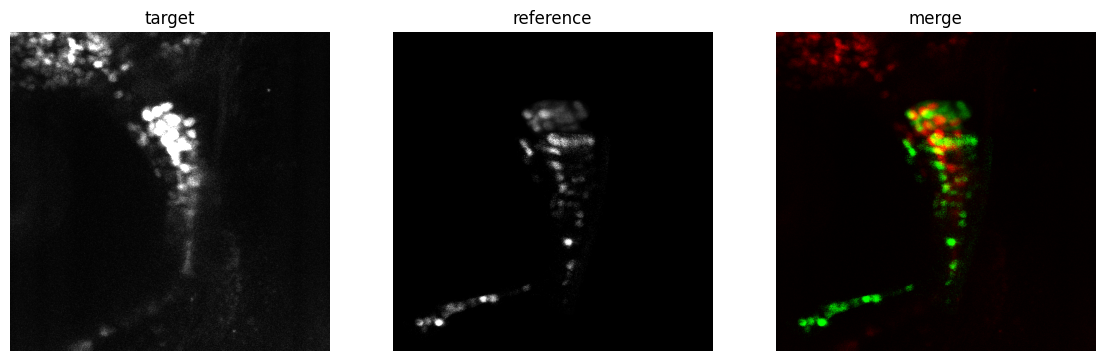

In [96]:
for registered_image in registered_images:
	fig, ax = plt.subplots(1, 3, figsize=(14, 6))

	ax[0].imshow(
		target_img,
		cmap="gray",
		vmin=target_vmin,
		vmax=target_vmax
	)
	ax[1].imshow(
		registered_image,
		cmap="gray",
		vmin=source_vmin, vmax=source_vmax
	)

	[a.axis("off") for a in ax]

	merge = np.zeros(
		(target_img.shape[0], target_img.shape[1], 3)
	)  # assumes same size images
	merge[:, :, 0] = 2 * target_img / target_img.max()
	merge[:, :, 1] = 2 * registered_image / registered_image.max()
	ax[-1].imshow(merge)

	ax[0].set_title("target")
	ax[1].set_title("reference")
	ax[-1].set_title("merge")
	plt.show()

# Find points on functional stack back to reference stack

Checking alignment transformations look good

In [97]:
# Randomly select n_points number of points and transform them
n_points = 10

mypoints = list()
fish_id = int(exp_folder.name.split('_')[-2])
save_path = exp_folder.joinpath("alignment_rev")

coms = random.sample(list(df[df.fish_id == fish_id]["com"]), n_points)
for x, y in coms:
	if flip_horizontal:
		mypoints.append((1024 - (x * 2), y * 2))
	else:
		mypoints.append((x * 2, y * 2))
    
rev_points = sitkalignment.transform_points(Path(save_path), mypoints)

ELASTIX version: 5.0.1
Command line options from ElastixBase:
-out      /Volumes/Rapid/Arinel_et_al_2025/Data/Fig3/elavl3H2BGCaMP8m_8dpf_fed_eggwater_0mM_18_20231206/alignment_rev/
-threads  unspecified, so all available threads are used
-def      /Volumes/Rapid/Arinel_et_al_2025/Data/Fig3/elavl3H2BGCaMP8m_8dpf_fed_eggwater_0mM_18_20231206/alignment_rev/point_set.txt
-jac      unspecified, so no det(dT/dx) computed
-jacmat   unspecified, so no dT/dx computed
Calling all ReadFromFile()'s ...
  The default value "false" is used instead.
  The default value "false" is used instead.
  Calling all ReadFromFile()'s took 0.008432 s
Transforming points ...
  The transform is evaluated on some points, specified in the input point file.
  Reading input point file: /Volumes/Rapid/Arinel_et_al_2025/Data/Fig3/elavl3H2BGCaMP8m_8dpf_fed_eggwater_0mM_18_20231206/alignment_rev/point_set.txt
  Input points are specified in world coordinates.
  Number of specified input points: 10
  The input points are 

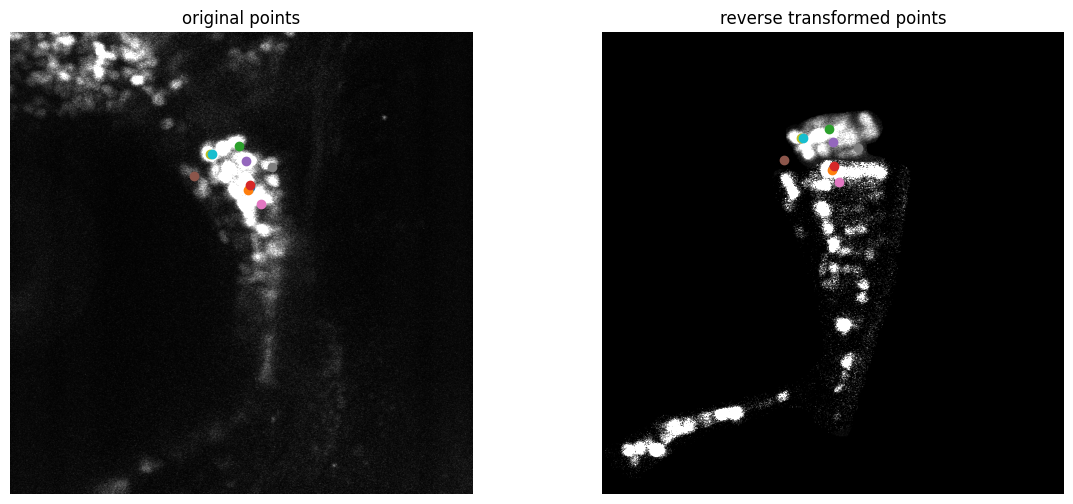

In [98]:
# Plot the original points on the target image vs. transformed points on the reference image
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0].imshow(
    target_img,
    cmap="gray",
    vmin=0,
    vmax=1000 
)
for p in mypoints:
    ax[0].scatter(p[0], p[1])
ax[0].set_title('original points')

ax[1].imshow(
    source_img,
    cmap="gray",
    vmin=0,
    vmax=1000,
)
ax[1].set_title('reverse transformed points')
for p in rev_points:
    ax[1].scatter(p[0], p[1])

[a.axis("off") for a in ax]
plt.show()

In [ ]:
# Update the unrolled_temporal.h5 dataframe with the reverse transformed points
with os.scandir(data_folder) as exp_folders:
	for exp_f in exp_folders:
		if exp_f.name.startswith("elavl3H2BGCaMP8m"):
			exp_folder = exp_f.path
			save_path = os.path.join(exp_folder, "alignment_rev")

			# Since the reference is a left vagal ganglion, flip the right vagal ganglion recordings
			flip_horizontal = False
			with os.scandir(exp_folder) as entries:
				for entry in entries:
					if os.path.isdir(entry.path) and entry.name.startswith("vagal_L"):
						break
					elif os.path.isdir(entry.path) and entry.name.startswith("vagal_R"):
						flip_horizontal = True
						break

			# Load the unrolled_temporal.h5 file to add the reverse transformed points
			df = pd.read_hdf(os.path.join(exp_folder, "unrolled_temporal.h5"))
			df["com_aligned"] = None
			
			for i, row in df.iterrows():
				if flip_horizontal:
					rev_point = sitkalignment.transform_points(Path(save_path), [(1024 - (row.com[0]*2), row.com[1]*2)])
				else:
					rev_point = sitkalignment.transform_points(Path(save_path), [(row.com[0]*2, row.com[1]*2)])
				df.at[i, "com_aligned"] = (rev_point[0][0], rev_point[0][1])

			df.to_hdf(os.path.join(exp_folder, "unrolled_temporal.h5") , key='unrolled_temporal', mode='w')

## Assign neurons to regions

In [ ]:
# Folder where the vagal ganglion and posterior lateral line ganglion masks are
masks_folder = r"./reference_images/vagal/masks"

# The actual image reference image
reference_img_path = r"./reference_images/vagal/SUM_vagal_anatomystack.tif"
reference_img = imread(reference_img_path)

masks = dict()  # Dictionary to store the masks
with os.scandir(masks_folder) as entries:
	for entry in entries:
		if not entry.name.startswith(".") and entry.name.endswith('.tif'):
			mask_name = entry.name[:-4]
			mask = imread(entry.path)
			masks[mask_name] = mask

# Plot the masks on the reference image
plt.figure(figsize=(10, 10))
plt.imshow(reference_img, cmap="gray", vmax=100)

for mask in masks.values():
	plt.imshow(mask, alpha=0.5, cmap="gray")

In [ ]:
# Assign region names to the neurons in the unrolled_temporal.h5 file
with os.scandir(data_folder) as exp_folders:
	for exp_f in exp_folders:
		if exp_f.name.startswith("elavl3H2BGCaMP8m"):
			exp_folder = exp_f.path
			df = pd.read_hdf(os.path.join(exp_folder, "unrolled_temporal.h5"))

			# Add a new column to the dataframe to store the region names
			df["region_aligned"] = None

			for mask_name, mask in masks.items():
				# Only proceed if there are any positive pixels in the mask
				if len(np.where(mask[:, :] > 0)[0]) > 0:
					# Determine the rows where the com_aligned x, y coordinate values are within the mask
					for i, (x, y) in enumerate(df["com_aligned"]):
						if mask[y, x] > 0:
							df.at[i, "region_aligned"] = mask_name

			df.to_hdf(os.path.join(exp_folder, "unrolled_temporal.h5"), key='unrolled_temporal', mode='w')

In [ ]:
# Visualize the aligned points on the reference image with a given region
plt.figure(figsize=(10, 10))
plt.imshow(reference_img, cmap="gray", vmax=100)

with os.scandir(data_folder) as exp_folders:
	for exp_f in exp_folders:
		if exp_f.name.startswith("elavl3H2BGCaMP8m"):
			exp_folder = exp_f.path
			df = pd.read_hdf(os.path.join(exp_folder, "unrolled_temporal.h5"))
			
			for i, row in df.iterrows():
				if row["region_aligned"] is not None:
					plt.scatter(row["com_aligned"][0], row["com_aligned"][1])